In [1]:
import pprint
import pandas as pd
import asyncio
import aiohttp
import nest_asyncio
nest_asyncio.apply()
import time
import json
import pickle
import re
from stop_words import get_stop_words
import nltk
from nltk.stem.snowball import RussianStemmer
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/evgenii.zhivaikin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
async def async_request(url, params=None):
    async with aiohttp.request(method='GET', url=url, params=params) as response:
        result = await response.json()
    return result

In [5]:
async def get_gazbank_it_vacancies():
    # АО Газпромбанк, Газпромбанк-Инвест, Газпромбанк-Инвест Девелопмент Северо-Запад,
    # Газпромбанк Лизинг, Газпромбанк - Управление Активами, Электронная торговая площадка Газпромбанка
    vacancies_ids = []
    vacancies = []
    employers_ids = [169875, 3388, 1111946, 93294, 1846784, 214499]
    pages = [{
        'employer_id': employers_ids, 
        'per_page': 100, 
        'page': i, 
        'specialization': '1',
    } for i in range(2)]
    futures_pages = [async_request("https://api.hh.ru/vacancies", params) for params in pages]
    for future in asyncio.as_completed(futures_pages):
        vacancies_ids_batch = await future
        for vacancy in vacancies_ids_batch['items']:
            vacancies_ids.append(vacancy['id'])
    
    for i in range(0, 171, 10):
        future_vacancies = [async_request(f"https://api.hh.ru/vacancies/{vacancy_id}") for vacancy_id in vacancies_ids[i:i+10]]
        for future in asyncio.as_completed(future_vacancies): 
            vacancy = await future
            vacancies.append(vacancy)
        time.sleep(1)
    return vacancies
    
async def get_gazbank_it_companies():
    params = {'text': 'газпромбанк'}
    r = await async_request("https://api.hh.ru/employers", params)
    return r

In [6]:
ioloop = asyncio.get_event_loop()
companies = ioloop.run_until_complete(get_gazbank_it_companies())
#companies

In [7]:
ioloop = asyncio.get_event_loop()
vacancies = ioloop.run_until_complete(get_gazbank_it_vacancies())
#vacancies

In [8]:
len(list(filter(lambda x: x.get('errors') is not None, vacancies)))

In [3]:
mystem = Mystem()

def process_text(text):
    docs = []
    stop_words = stopwords.words("russian")
    doc = re.sub('<[^>]*>', '', text.lower())
    doc = re.sub('&quot;', '', doc)
    doc = re.sub(r'[^a-zа-я]+', ' ', doc, re.UNICODE)

    doc = doc.strip()
    doc = doc.replace('\u200b', ' ')
    doc = doc.replace('•', ' ')
    doc = doc.replace('-', ' ')
    doc = doc.replace('.', ' ')
    doc = doc.replace(',', ' ')
    doc = doc.replace('(', ' ')
    doc = doc.replace(')', ' ')
    doc = doc.replace('\n', ' ')
    words = mystem.lemmatize(doc.lower())
    #words = re.split(r'\s{1,} |\ |/', doc.strip())
    words = [word for word in words if word not in stop_words]
    #words = [stemmer.stem(word) for word in words]
    return ' '.join(words)

In [4]:
docs = []
for vacancy in vacancies:
    skills_str = ' '.join(skill['name'] for skill in vacancy['key_skills'])
    description = vacancy['description']
    text = f"{description} {skills_str}"
    docs.append(process_text(text))

NameError: name 'vacancies' is not defined

In [27]:
import pickle 

with open('cv', 'wb') as file:
    pickle.dump(vectorizer, file)

with open('idf', 'wb') as file:
    pickle.dump(transformer, file)
    

In [32]:
resume_example = """
Увлекаюсь всем, что касается IT. Благодаря постоянной работе в команде и практически постоянному участию в различных конкурсах на протяжении уже более трёх лет приобрел коммуникационные, лидерские и организационные навыки. В любой работе часто проявляю заинтересованность, оптимизм, умение распределять задачи, и беру на себя ответственность за результат. Прошел "Зимнюю Школу" от УрФУ, где развивал свои soft-skills.
Во внерабочее время занимаюсь различными коммерческими и некоммерческими проектами на языке python (FastAPI, Django, Flask и пр.). Немного занимаюсь DevOps и ML.
Python
SQL
RabbitMQ
Redis
Django Framework
Flask
Node.js
Celery
Design Patterns
Docker
DevOps
CI/CD
"""

In [33]:

# with open('cv', 'rb') as file:
#     vectorizer = pickle.load(file)

# with open('idf', 'rb') as file:
#     transformer = pickle.load(file)

vacancies = json.load(open("vacancies.json" ))

In [34]:
docs = []
for vacancy in vacancies:
    skills_str = ' '.join(skill['name'] for skill in vacancy['key_skills'])
    description = vacancy['description']
    title = vacancy['name']
    text = f"{description} {skills_str} {title}"
    docs.append(process_text(text))

# X = vectorizer.fit_transform(docs)
# X = transformer.fit_transform(X)

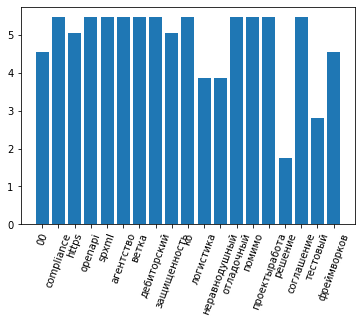

In [61]:
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import pandas as pd
import matplotlib.pyplot as plt

vectorizer = CountVectorizer()
transformer = TfidfTransformer()
X = vectorizer.fit_transform(docs)
X = transformer.fit_transform(X)

idf_values = pd.DataFrame(transformer.idf_, index=vectorizer.get_feature_names(),columns=["idf_weights"])
idf_values.sort_values('idf_weights')

plt.bar(list(idf_values.index)[::150], list(idf_values['idf_weights'])[::150])
plt.xticks(rotation=70)

plt.show()

In [36]:
resume_doc = process_text(resume_example)
resume_vals = vectorizer.transform([resume_doc])
resume_idfs = transformer.transform(resume_vals)
resume_vals

<1x2805 sparse matrix of type '<class 'numpy.int64'>'
	with 49 stored elements in Compressed Sparse Row format>

In [37]:
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [38]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarities = cosine_similarity(resume_idfs, X).flatten()

In [39]:
vacancies_ids = [vacancy['id'] for vacancy in vacancies]
resume_similarity_df = pd.DataFrame(cosine_similarities, index=vacancies_ids, columns=["similarity"])
resume_similarity_df.sort_values('similarity')

,similarity
39264249,0.004056
40586526,0.004404
39846285,0.006476
40493330,0.006495
40545443,0.006766
...,...
38874356,0.130612
36455463,0.131017
36567025,0.156416
39775853,0.158898


In [43]:
sims = list(zip(vacancies_ids, cosine_similarities))
sims.sort(key=lambda x: x[1], reverse=True)
sims[:5]

[('37622366', 0.1620218139590954),
 ('38845851', 0.14704278374620117),
 ('39775853', 0.14129821425042532),
 ('38665526', 0.14073149148133382),
 ('38874356', 0.12837255189559668)]